In [1]:
%matplotlib inline
%config IPython.matplotlib.backend = "retina"
from matplotlib import rcParams
rcParams["savefig.dpi"] = 300
rcParams["figure.dpi"] = 300

In [2]:
import numpy as np
import glob
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import la_forge.core as co
import corner
from IPython.display import display, Math
from IPTA_DR2_analysis.model_blocks import lite_Tspan, full_Tspan

In [3]:
datasets = ['dr2full', 'dr2lite_unfiltered_53', 'edr2']
labels = ['Full DR2', 'DR2 Lite', 'EDR2']#, 'EDR2 filtered']
Nfreqs = [13, 13, 13]
save_label = ''#'_compare_filters'
noisetype = 'advnoise'
model_names = [f'CRN{Nf}_g4p3_{noisetype}' for Nf in Nfreqs]
# specify pulsar, dataset, model, and number of cores
project_path = '/vast/palmer/home.grace/bbl29/IPTA_DR2_analysis'
# where to save figures
figsave = f'{project_path}/figs/dataset_comparisons/gwb'
load_pt_chains = False

In [4]:
# get cores
cores = {}
for ds, mn, lbl in zip(datasets, model_names, labels):
    corepath = f'/vast/palmer/home.grace/bbl29/project/IPTA_DR2_analysis/{ds}/{mn}/core.h5'
    cores[lbl] = co.Core(corepath=corepath, burn=0)

In [7]:
chain_idxs = {}
ln_weights = {}
for ds, mn, lbl in zip(datasets, model_names, labels):
    core_save_dir = f'/vast/palmer/home.grace/bbl29/project/IPTA_DR2_analysis/{ds}/{mn}'
    chain_idxs[lbl] = []
    ln_weights[lbl] = []
    for path in glob.glob(f'{core_save_dir}/HD_reweighting/*'):
        chain_idxs[lbl].append(np.loadtxt(f'{path}/chain_idxs.txt'))
        ln_weights[lbl].append(np.loadtxt(f'{path}/ln_weights.txt'))
    chain_idxs[lbl] = np.array(np.concatenate(chain_idxs[lbl]), dtype=int)
    ln_weights[lbl] = np.concatenate(ln_weights[lbl])
    chain_idxs[lbl] = chain_idxs[lbl][~np.isnan(ln_weights[lbl])]
    ln_weights[lbl] = ln_weights[lbl][~np.isnan(ln_weights[lbl])]
chain_idxs, ln_weights

({'Full DR2': array([     7,     61,    115, ..., 539900, 539954, 540008]),
  'DR2 Lite': array([     7,     42,     77, ..., 702528, 702563, 702598]),
  'EDR2': array([    11,     65,    119, ..., 539900, 539954, 540008])},
 {'Full DR2': array([ 0.10345601,  0.85970498,  1.69006627, ...,  0.72526593,
          1.06692608, -1.39135372]),
  'DR2 Lite': array([-0.78145342, -0.78847674, -1.31915032, ..., -1.00684468,
         -0.99787585,  1.48160565]),
  'EDR2': array([ 1.02505928,  1.71776549,  0.09488739, ...,  1.68866636,
         -0.46051696,  0.7873709 ])})

## Get Bayes fac

In [48]:
for lbl in labels:
    print(lbl)
    Ns = len(ln_weights[lbl])
    mean_wgt = np.nanmean(np.exp(ln_weights[lbl]))
    sigma_wgt = np.nanstd(np.exp(ln_weights[lbl]))
    neff = Ns/(1 + (sigma_wgt/mean_wgt)**2)
    sigma_B = sigma_wgt/np.sqrt(neff)
    D_KL = np.log(mean_wgt) - np.mean(ln_weights[lbl])
    display(Math(fr'N_{{\rm{{eff}}}} = {int(neff)}'))
    display(Math(fr'\mathcal{{E}} = {neff/Ns:0.2f}'))
    display(Math(fr'\mathcal{{B}}^{{\rm{{HD}}}}_{{\rm{{CRN}}}} = {mean_wgt:0.3f} \pm {sigma_B:0.3f}'))
    display(Math(fr'D_{{KL}} = {D_KL:0.3f}'))

Full DR2


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

DR2 Lite


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

EDR2


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [18]:
sigma_B, neff

(8.188106006899384, 0.28970777185690544)

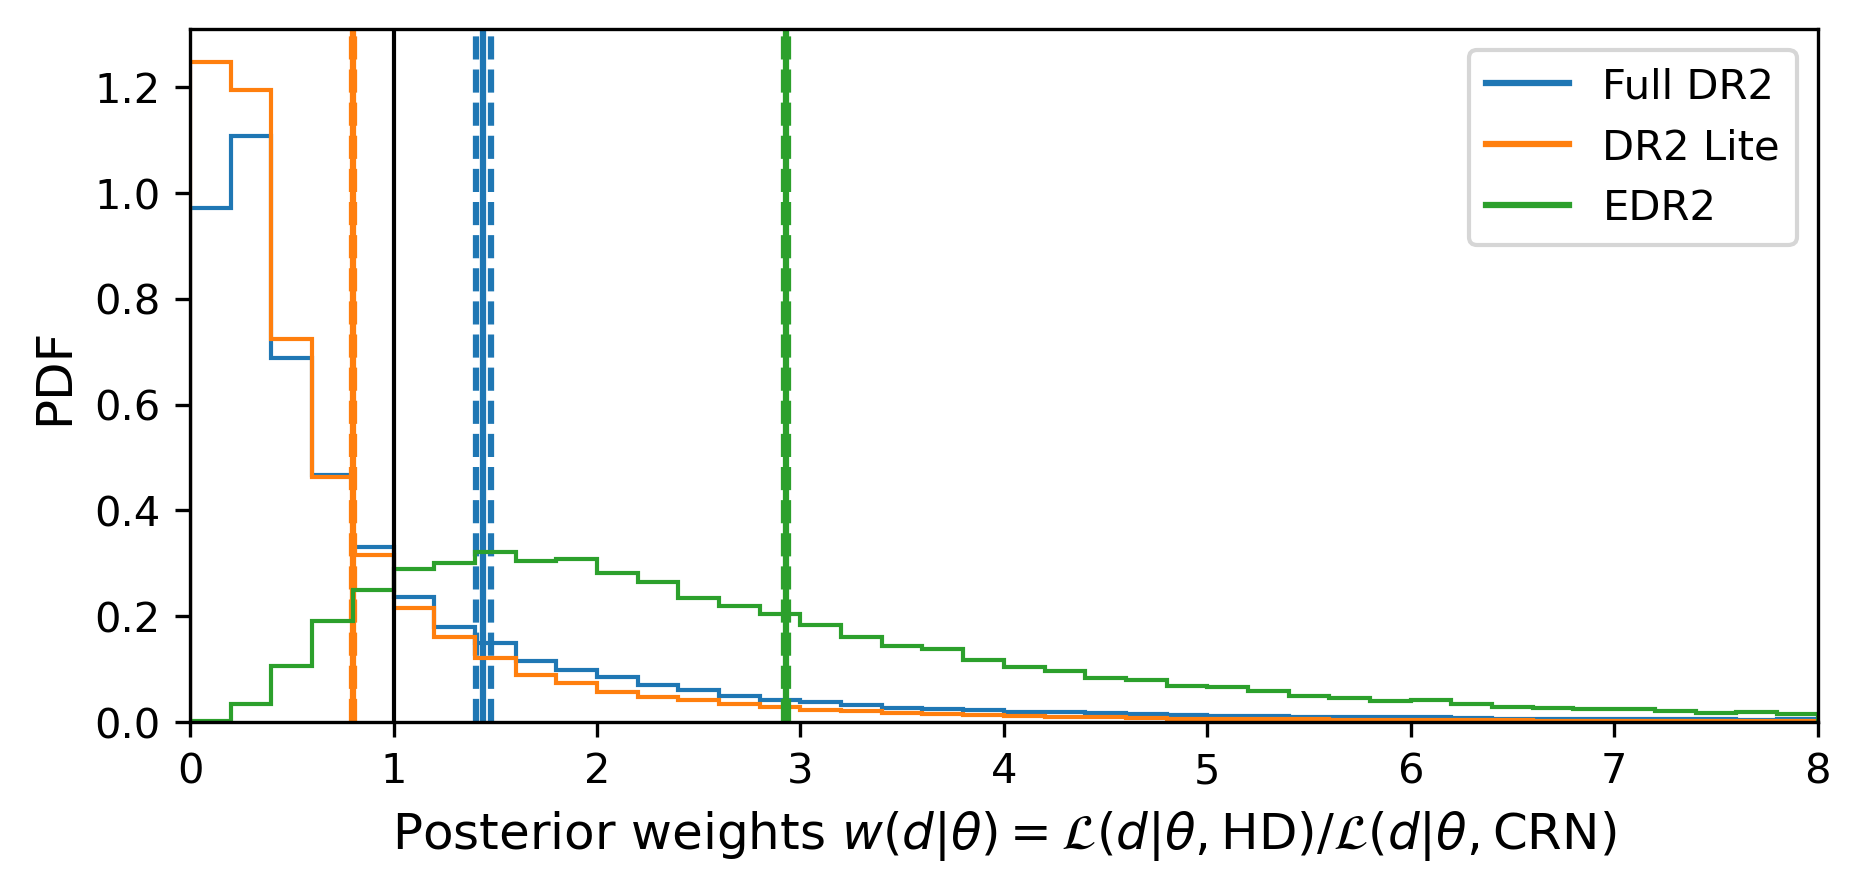

In [35]:
plt.figure(figsize=(7,3))
for i, lbl in enumerate(labels):
    PLR = np.exp(ln_weights[lbl])
    Ns = len(ln_weights[lbl])
    mean_wgt = np.nanmean(PLR)
    sigma_wgt = np.nanstd(PLR)
    neff = Ns/(1 + (sigma_wgt/mean_wgt)**2)
    sigma_B = sigma_wgt/np.sqrt(neff)
    plt.hist(PLR, bins=40, histtype='step', density=True,
             range=(0,np.min([8,np.max(PLR)])), color=f'C{i}')
    #plt.axvline(10**0.3, color='C1',
    #            label=(r'Antoniadis+2022 result ($\mathcal{B}^{\rm{HD}}_{\rm{CARN}} =$'+
    #                   f'{np.round(10**0.3, decimals=3)})'))
    plt.axvline(mean_wgt, color=f'C{i}', label=lbl)
#                label=fr'$\mathcal{{B}}^{{\rm{{HD}}}}_{{\rm{{CRN}}}} = {mean_wgt:0.3f}\pm{sigma_B:0.3f}$ ({lbl})')
    plt.axvline(mean_wgt+sigma_B, color=f'C{i}', ls='dashed')
    plt.axvline(mean_wgt-sigma_B, color=f'C{i}', ls='dashed')
    plt.xlabel(r'Posterior weights $w(d|\theta) = '
               r'\mathcal{L}(d|\theta,\mathrm{HD})/\mathcal{L}(d|\theta,\mathrm{CRN})}$', fontsize='large')
    plt.ylabel('PDF', fontsize='large')
    plt.xlim([0,8])
    #plt.title('BF results from reweighting')
    plt.legend()
plt.axvline(1, alpha=1, lw=1, color='k')#, label='BF = 1')

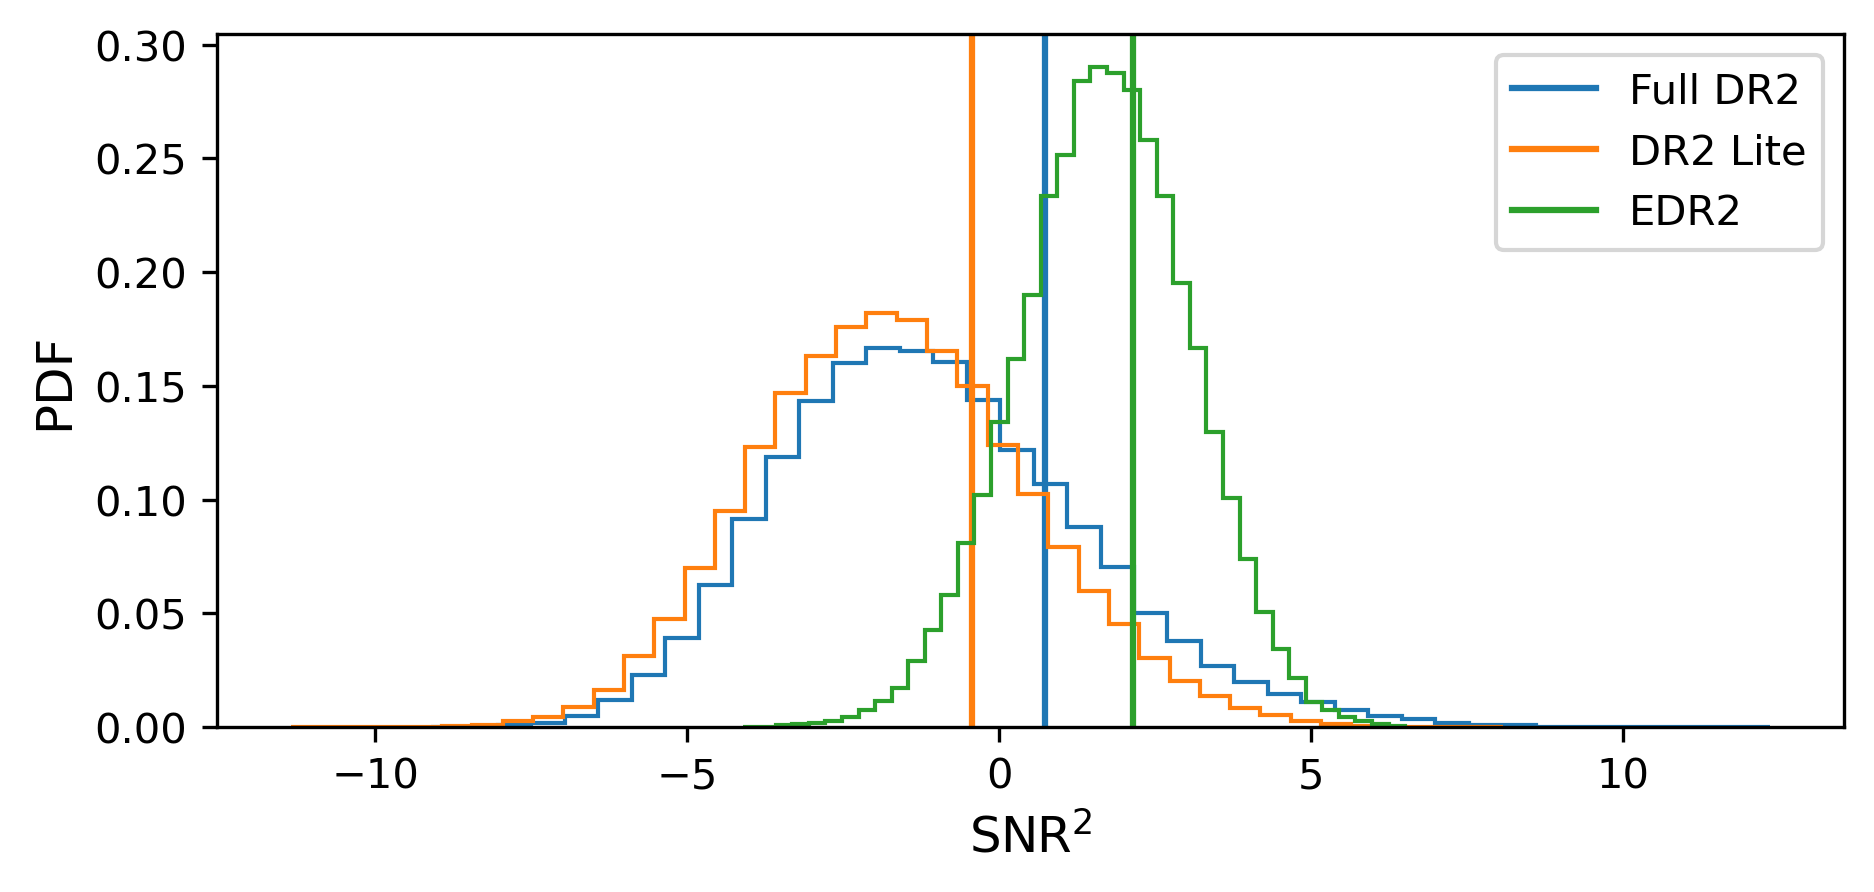

In [57]:
# heuristic SNR estimate
plt.figure(figsize=(7,3))
for i, lbl in enumerate(labels):
    PLR = np.exp(ln_weights[lbl])
    Ns = len(ln_weights[lbl])
    mean_wgt = np.nanmean(PLR)
    sigma_wgt = np.nanstd(PLR)
    neff = Ns/(1 + (sigma_wgt/mean_wgt)**2)
    sigma_B = sigma_wgt/np.sqrt(neff)
    D_KL = np.log(mean_wgt) - np.mean(ln_weights[lbl])
    SNR_sq = 2*np.log(PLR)# - 2*D_KL
    SNR_sq_mean = 2*np.log(mean_wgt)# - 2*D_KL
    plt.hist(SNR_sq, bins=40, histtype='step', density=True, color=f'C{i}')
    #plt.axvline(10**0.3, color='C1',
    #            label=(r'Antoniadis+2022 result ($\mathcal{B}^{\rm{HD}}_{\rm{CARN}} =$'+
    #                   f'{np.round(10**0.3, decimals=3)})'))
    plt.axvline(SNR_sq_mean, color=f'C{i}', label=lbl)
    #plt.axvline(mean_wgt+sigma_B, color=f'C{i}', ls='dashed')
    #plt.axvline(mean_wgt-sigma_B, color=f'C{i}', ls='dashed')
    plt.xlabel(r'SNR$^2$', fontsize='large')
    plt.ylabel('PDF', fontsize='large')
    #plt.xlim([0,8])
    #plt.title('BF results from reweighting')
    plt.legend()

In [58]:
def make_labels(params, psrname, add_psrname=True):
    labels = []
    if add_psrname:
        add = psrname+'\n'
    else:
        add = ''
    for p in params:
        if 'dm_gp_gamma' in p:
            labels.append(add+r'$\gamma_{\rm{DM}}$')
        elif 'dm_gp_log10_A' in p:
            labels.append(add+r'$\log_{10}A_{\rm{DM}}$')
        elif 'red_noise_gamma' in p:
            labels.append(add+r'$\gamma_{\rm{IRN}}$')
        elif 'red_noise_log10_A' in p:
            labels.append(add+r'$\log_{10}A_{\rm{IRN}}$')
        elif p == 'crn_log10_A':
            labels.append(r'$\log_{10}A_{\rm{CRN}}$')
        elif p == 'crn_gamma':
            labels.append(r'$\gamma_{\rm{CRN}}$')
        elif 'exp1_log10_Amp' in p:
            labels.append(add+r'$\log_{10}A_{\rm{exp}}$')
        elif 'exp1_log10_tau' in p:
            labels.append(add+r'$\log_{10}\tau_{\rm{exp}}$')
        elif 'exp1_t0' in p:
            labels.append(add+r'$t_{\rm{exp}}$')
        else:
            labels.append(p)
    return labels

In [60]:
labels, datasets

(['Full DR2', 'DR2 Lite', 'EDR2'],
 ['dr2full', 'dr2lite_unfiltered_53', 'edr2'])

In [61]:
cores

{'Full DR2': <la_forge.core.Core at 0x14f860c97910>,
 'DR2 Lite': <la_forge.core.Core at 0x14f88931b880>,
 'EDR2': <la_forge.core.Core at 0x14f88931bd90>}

In [ ]:
psrnames = np.unique([p.split('_')[0] for p in cores['Full DR2'].params if 'J' in p])
for psrname in psrnames:
    fig = None
    for i, lbl in enumerate(labels):
        #corepath = f'/vast/palmer/home.grace/bbl29/project/IPTA_DR2_analysis/dr2full/advnoise/{psrname}/core.h5'
        #if 'Lite' in lbl:
        #    corepath = corepath.replace('dr2full', 'dr2lite_unfiltered')
        #if not os.path.isfile(corepath):
        #    continue
        #c_psr = co.Core(corepath=corepath, burn=0)
        params = [p for p in cores[lbl].params if psrname in p] + [p for p in cores[lbl].params if 'crn' in p]
        if len(params) < 2:
            continue
        p_idxs = [cores[lbl].params.index(p) for p in params]
        p_labels = make_labels(params, psrname, add_psrname=False)
        #fig = corner.corner(cores[lbl].chain[chain_idxs[lbl]][:,p_idxs], levels=(0.68,0.95), labels=p_labels,
        #                    color='C0', plot_density=False, plot_datapoints=False,
        #                    no_fill_contours=True, hist_kwargs={'density':True},
        #                    label_kwargs={'fontsize':20})
        if i == 0:
            fig = corner.corner(cores[lbl].chain[chain_idxs[lbl]][:,p_idxs], levels=(0.68,0.95), labels=p_labels,
                                color=f'C{i}', plot_density=False, plot_datapoints=False,
                                weights=np.exp(ln_weights[lbl]),
                                no_fill_contours=True, hist_kwargs={'density':True})
        else:
            fig = corner.corner(cores[lbl].chain[chain_idxs[lbl]][:,p_idxs], levels=(0.68,0.95), fig=fig,
                                color=f'C{i}', plot_density=False, plot_datapoints=False,
                                weights=np.exp(ln_weights[lbl]),
                                no_fill_contours=True, hist_kwargs={'density':True})
        #lines = [mlines.Line2D([],[],color='C0',label='CRN')]
        #lines += [mlines.Line2D([],[],color='C1',label='HD (reweighting)')]
        #fig.legend(handles=lines, fontsize=20)
    fig.suptitle(f'PSR {psrname}', fontsize=30)
    plt.show()

In [72]:
cores[lbl].chain[chain_idxs[lbl]][:,p_idxs]

array([[-14.36567755],
       [-14.30408976],
       [-14.45332193],
       ...,
       [-14.35868067],
       [-14.4082014 ],
       [-14.52334092]])

In [75]:
p_idxs, params, lbl

([109], ['crn_log10_A'], 'EDR2')

In [41]:
for i, lbl in enumerate(labels):
    PLR = np.exp(ln_weights[lbl])
    print(f'{lbl}, {np.count_nonzero(PLR > 1)/len(PLR):0.2f}')

Full DR2, 0.31
DR2 Lite, 0.22
EDR2, 0.89


In [45]:
for i, lbl in enumerate(labels):
    PLR = np.exp(ln_weights[lbl])
    print(f'{lbl}, {np.percentile(PLR, 95):0.2f}')

Full DR2, 5.04
DR2 Lite, 2.74
EDR2, 7.08


In [44]:
for i, lbl in enumerate(labels):
    PLR = np.exp(ln_weights[lbl])
    print(f'{lbl}, {np.percentile(PLR, 5):0.2f}')

Full DR2, 0.10
DR2 Lite, 0.08
EDR2, 0.73


In [ ]:
np.percentile()